Folder "alexnet_npc" exists, cancelling download request...
Model loaded.
INFO:tensorflow:Restoring parameters from alexnet_npc/model.ckpt-399999
Scores: 79.13880920410156, Saving checkpoint - 0
Scores: -16.77753448486328, Saving checkpoint - 100
Scores: -18.13184928894043, Saving checkpoint - 199
[-1.5348792 14.086887  15.258841 ]


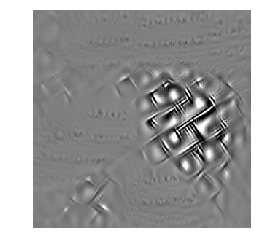

In [2]:
import h5py
import tensorflow as tf
import os
import numpy as np
from npc.model import Model
from npc.synthesizer import Synthesizer
import npc.losses as losses
import wget
from tqdm import tqdm
import zipfile
import matplotlib.pyplot as plt
%matplotlib inline

npa = np.array

# desired control goal
mode = 'stretch'  # ['stretch', 'ohp']
neuron_id = 45  # index of neuron to optimize for
assert mode in ['stretch', 'ohp']

# this variable determines the index of gpu to use (may need to remove it)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

def _dl_files(url='https://s3.amazonaws.com/npc-v4-data/model_files/alexnet_npc.zip'):
    if os.path.exists('alexnet_npc/alexnet_model.py'):
        print('Folder "alexnet_npc" exists, cancelling download request...')
    else:
        print('Downloading files from S3...')
        wget.download(url)
        z = zipfile.ZipFile('alexnet_npc.zip', 'r')
        z.extractall()
        z.close()
        print('Download finished!')
        
        
# Download model features from S3
_dl_files()

# Load mapping weights
with h5py.File('alexnet_npc/monkey_m_mapping.h5'
)as h5file:
    weights = {k: npa(h5file[k]) for k in h5file.keys()}

# Fixed settings
checkpoint_path = 'alexnet_npc/model.ckpt-399999'
readout_layer = 'conv3'
output_layer = 'output'
ph_shape = (1, 299, 299, 1)
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)

# synthesis loop
with tf.Graph().as_default() as g, tf.Session() as sess:
    np.random.seed(0)
    initial_image = np.random.uniform(low=-1, high=1, size=ph_shape)
    initial_image /= 2 * np.max(np.abs(initial_image))
    
    image_ph = tf.placeholder(tf.float32, shape=ph_shape, name='image_ph')
    model = Model(checkpoint_path=checkpoint_path, model_name='alexnet', image=image_ph,
                  graph=g, sess=sess, gpu_options=gpu_options)
    model.map_output_sep(weights=weights, readout_layer=readout_layer)
    
    # Construct the score function using TF functions
    if mode == 'stretch':
        score_func = tf.reshape(model.endpoints[output_layer], (-1,))[neuron_id]
    else:
        score_func = tf.nn.softmax(model.endpoints[output_layer], axis=-1)[neuron_id]
    
    ls = [losses.CustomScore(model, weight=1.0, score_func=score_func),
          losses.TvLoss(model, weight=500.0)]
    synth = Synthesizer(model=model, losses=ls)
    preds, checkpoints, outputs = synth.run(num_iterations=200, initial_image=initial_image,
                                            jitter=True, monitor_varaible=output_layer, learning_rate=0.01)
    print(np.squeeze(outputs)[:, 1])
    plt.figure()
    plt.imshow(np.squeeze(checkpoints[-1]), cmap='gray')
    plt.axis('off')
    plt.show()
